In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import gc

from scipy.integrate import quad,dblquad
from scipy.interpolate import CubicSpline

from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


### Load the same functions as before

In [2]:
gamma = 1.0
kBT = 1.0
dt = 0.001
eta_sig = np.sqrt(2*kBT*gamma/dt)

tf = 2
nsteps = int(tf/dt)

In [3]:
#Compute the potential
@numba.jit(nopython=True)
def getPotential(x):
    return 10* (x-1)**2 * (x+1)**2
    
#Compute the conservative force
@numba.jit(nopython=True)
def getForce(x):
    return -40 * x * (x-1) * (x+1) 
    
#Propagate the system for one step 
#without any control forces
@numba.jit(nopython=True)
def langevinStep(x,eta_sig=eta_sig,dt=dt):
    eta = np.random.normal(0,eta_sig)
    f = getForce(x)
    return x + (f + eta)*dt/gamma, eta

#Indicator function for A well
@numba.jit(nopython=True)
def hA(x):
    return x < -0.7
    
#Indicator function for B well
@numba.jit(nopython=True)
def hB(x):
    return x > 0.7

#Get nconfs steady state configurations within some domain given by
#the indicator. x0 defines the location to start the sampling
#and lag is the number of timesteps after which a configuration is stored
@numba.jit(nopython=True)
def getSteadyStateConfs(nconfs, x0, indicator, lag=100):
    confs = np.zeros((nconfs))
    z = 0
    x = x0
    while z < nconfs:
        for i in range(lag):
            x = langevinStep(x)[0]
        if indicator(x):
            confs[z] = x
            z += 1
        else:
            x = x0
    return confs

#Helper for obtaining reactive trajectories
@numba.jit(nopython=True)
def getReactiveHelper(indicator,nsteps,init,
                      eta_sig=eta_sig,dt=dt):
    traj= np.zeros((nsteps,2))
    while not indicator(traj[-1,0]):
        traj[0,0] = init
        for i in range(1,nsteps):
            x,eta = langevinStep(traj[i-1,0],
                                 eta_sig=eta_sig,dt=dt)
            traj[i,0] = x
            traj[i-1,1] = eta
    return traj

#Obtain ntraj trajectories of total steps nsteps
#starting from a set of configurations given by init_confs 
#and ending in a domain given by the indicator.
#Returns an array of dimensions [ntraj,nsteps,2]
#where the value of the last axis corresponds to the configuration
#and the second value corresponds to the noises.
def getReactiveTrajectories(init_confs,ntraj,nsteps,indicator
                ,eta_sig=eta_sig, dt=dt):
    traj = np.zeros((ntraj,nsteps,2))
    z = 0
    for i in tqdm(range(ntraj)):
        init = np.random.choice(init_confs)
        traj[i] = getReactiveHelper(indicator,nsteps,init)
    return traj


In [4]:
# Get the second eigenvalue using Kramer's method: 
# mu2 = kAB + kBA
def getMu2(xA=-1.,xB=1.,kBT=kBT,gamma=gamma):
    def func(x,y):
        return np.exp((-getPotential(y) + getPotential(x))/kBT)
    kAB = (kBT/gamma)/dblquad(func, 3*xA, xB, lambda x: x, xB,epsrel = 1e-018)[0]
    kBA = (kBT/gamma)/dblquad(func, 3*xB, xA, lambda x: x, xA,epsrel = 1e-018)[0]
    mu2 = kAB + kAB
    return mu2

#Get probability within well A and B
def getProbabilities(xA=-0.7,xB=0.7,kBT=kBT):
    Z = quad(lambda x: np.exp(-getPotential(x)/kBT),-10,10)[0]
    pA = quad(lambda x: np.exp(-getPotential(x)/kBT),-10,xA)[0]/Z
    pB = quad(lambda x: np.exp(-getPotential(x)/kBT),xB,10)[0]/Z
    return pA,pB

# Compute the committor numerically and fit it using a spline
def getCommittorSplines(kBT=kBT,gamma=gamma,sigma=0.1):
    xst = np.linspace(-1.5,1.5,20000)
    def com(x):
        return np.exp(getPotential(x)/kBT)
    xA = -1.0
    xB = 1.0
    
    Aidx = np.argmin((xst-xA)**2)
    Bidx = np.argmin((xst-xB)**2)

    J = 1/quad(com,xA,xB)[0]
    qss = np.zeros((xst.shape[0]))
    qss[Aidx:Bidx] = np.array([quad(com,xA,i,epsrel = 1e-020)[0] for i in xst[Aidx:Bidx]])*J
    qss[:Aidx] = 0.
    qss[Bidx:] = 1.
    
    #Smooth the committor such that its gradient goes to 0 continuously
    if sigma > 1.0e-10:
        xl = xA-sigma/2
        xr = xA+sigma/2
        Ridx = np.argmin((xst-xr)**2)
        Lidx = np.argmin((xst-xl)**2)
        
        B = np.zeros((6))
        A = np.zeros((6,6))
        
        B[3] = quad(com,xA,xr,epsrel = 1e-020)[0]*J
        B[4] = com(xr)*J
        B[5] = -getForce(xr) * com(xr) * J
    
        A =  np.array([[0,0,0,0,0,1],
                       [0,0,0,0,1,0],
                       [0,0,0,2,0,0],
                       [sigma**5,sigma**4,sigma**3,sigma**2,sigma,1],
                       [5*sigma**4,4*sigma**3,3*sigma**2,2*sigma,1,0],
                       [20*sigma**3,12*sigma**2,6*sigma,2,0,0]])
        C = np.linalg.inv(A)@B
        qss[Lidx:Ridx] = np.sum([C[i]*np.power(xst[Lidx:Ridx]-xl,5-i) for i in range(6)],axis=0)

    qssSpline = CubicSpline(xst,qss)
    dqssSpline = CubicSpline.derivative(qssSpline)
    
    return qssSpline, dqssSpline
    

#Get the control force function
def getControlForceFunction(qssSpline,dqssSpline,pB,mu2,kBT=1.0):
    def getControlForce(x,t):
        return 2*kBT*dqssSpline(x)/(qssSpline(x) + pB*(np.exp(mu2*t)-1))
    return getControlForce

#Parallel langevin step with the control force
def langevinStepDriven(x,t,ntraj,getControlForce,eta_sig=eta_sig,dt=dt):
    eta = np.random.normal(0,eta_sig,(ntraj))
    lamb = getControlForce(x,t)
    f = getForce(x)
    return x + (f+lamb+eta)*dt/gamma, eta, lamb

#Get trajectories initiated at init_confs and
# driven with the control force getControlForce
# The function returns an array of [ntraj, nsteps, 3]
# where the values of the last axis corresponds to the
# configurations, noises and the control forces respectively.
def getDrivenTrajectories(init_confs, nsteps, getControlForce, 
                          eta_sig=eta_sig, dt=dt,verbose=True):
    ntraj = init_confs.shape[0]
    traj = np.zeros((ntraj, nsteps, 3))
    traj[:,0,0] = init_confs
    if verbose:
        rng = tqdm(range(1,nsteps))
    else:
        rng = range(1,nsteps)
    for i in rng:
        t = (nsteps-i)*dt
        traj[:,i,0],traj[:,i-1,1], traj[:,i-1,2] = langevinStepDriven(traj[:,i-1,0],t
                                                    ,ntraj, getControlForce,eta_sig,dt)
    return traj



In [5]:
pA,pB = getProbabilities()
mu2 = getMu2()

# 1. Sensitivity to Observation Time $t_f$


In [6]:
ntraj = 10000
confs_A = getSteadyStateConfs(ntraj,-1.,hA)
tfs = np.array([0.2,0.3,0.5,0.75,1.0,1.5,2.0,3.0,4.0,5.0,7.5,10.0])
Nsteps = (tfs/dt).astype(int)
U = np.zeros((tfs.shape[0],ntraj))
idx = np.zeros((tfs.shape[0],ntraj),dtype=bool)
qssSpline, dqssSpline = getCommittorSplines()
getControlForce = getControlForceFunction(qssSpline,dqssSpline,pB,mu2)

for i in tqdm(range(tfs.shape[0])):
    driven_traj = getDrivenTrajectories(confs_A, Nsteps[i], getControlForce,verbose=False)
    idx[i] = hB(driven_traj[:,-1,0])
    U[i] = -np.sum(driven_traj[...,-1]**2 + 2*driven_traj[...,-1]*driven_traj[...,-2],
                    axis=-1)*dt/(4*gamma*kBT)
    

  0%|          | 0/12 [00:00<?, ?it/s]

### To understand sensitivity to $t_f$, we first consider the timescale in which the second order expansion of the side-side correlation function $kt_f$ is close to the exact form $\langle h_{B|A}\rangle_{0}$ that is computed using a spectral expansion up to 10 orders. 
### We plot the ratio of reactive trajectories obtained using the control force $\langle h_{B|A}\rangle_{\lambda}$ for different observation times $t_f$, and the value of the estimator $\langle \Delta U_{\lambda} \rangle_{B|A,\lambda} + \ln \langle h_{B|A}\rangle_{\lambda}$ along with the exact value of the side-side correlation function computed using the 10th order spectral expansion.
### The plots shows that the only error arising from the approximate form of the Doob drift culminates in the decrease in reactivity, and leaves the statistics of the reactive trajectories indistinguishable from the original one.

(-1.9, 2.4)

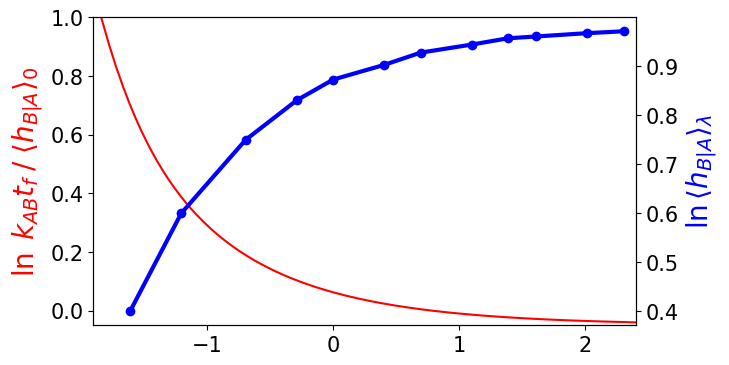

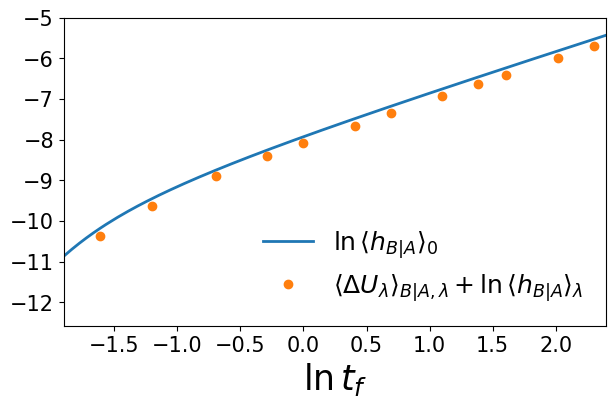

In [7]:
CAB_exact = np.loadtxt('../jupyter_data/1D_DW_CAB.dat',skiprows=1)
CAB_2 = pB*(1-np.exp(-mu2*CAB_exact[:,0]))

driven_hBA = np.mean(idx,axis=-1)
driven_est = np.array([np.mean(U[i][idx[i]]) for i in range(tfs.shape[0])]) + \
                np.log(driven_hBA)
fig,ax = plt.subplots(figsize=(7,4))


ax.plot(np.log(CAB_exact[:,0]),np.log(CAB_2/CAB_exact[:,1]),'r')
ax.tick_params(labelsize=15)
ax.set_ylabel('$\\ln \;  k_{AB}t_f\;/\;\\langle h_{B|A}\\rangle_0 $',fontsize=20,c='r')
ax.set_ylim(-0.05,1.)
ax2=ax.twinx()

ax2.plot(np.log(tfs),driven_hBA,'-o',lw=3,c='b')
ax2.set_xlabel('$t_f/\\tau$',fontsize=25)

ax2.tick_params(labelsize=15)
ax2.set_ylabel('$\\ln \\langle h_{B|A} \\rangle_{\\lambda}$',fontsize=20,c='b')
plt.xlim(-1.9,2.4)

plt.figure(figsize=(7,4))
plt.plot(np.log(CAB_exact[:,0]),np.log(CAB_exact[:,1])
         ,label='$\\ln \\langle h_{B|A} \\rangle_{0}$',lw=2)

plt.plot(np.log(tfs),driven_est,'o', \
         label='$\\langle \\Delta U_{\\lambda} \\rangle_{B|A,\\lambda}' + 
                 ' + \\ln \\langle h_{B|A} \\rangle_{\\lambda}$')

plt.xlabel('$\\ln t_f$',fontsize=25)
plt.legend(fontsize=18,frameon=False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-1.9,2.4)

### To illustrate that the statistics of the reactive trajectory ensemble is unchanged, we compare the ensemble of driven reactive trajectories with that of the undriven reactive trajectories for the smallest observation time $t_f = 0.5 \tau_{\mathrm{mol}}$.

In [8]:
driven_traj = getDrivenTrajectories(getSteadyStateConfs(20000,-1.,hA), Nsteps[0]
                                    , getControlForce,verbose=False)
idx0 = hB(driven_traj[:,-1,0])
driven_traj = driven_traj[idx0]
undriven_traj = np.load('../jupyter_data/1D_DW_reactive_undriven_tf_0.2.npy')


### As observed below the transient reactive densities of the driven and undriven trajectories show close to exact statistics.

In [9]:
def getDensities(dat,xst):
    prob ,b = np.histogram(dat,xst,density=True)
    cum = np.array([np.sum(prob[:i]) for i in range(prob.shape[0])])
    cum /= cum[-1]
    return prob,cum
    
xst = np.linspace(-1.45,1.45,80) 
xst_= 0.5*(xst[1:] + xst[:-1])
fig,ax = plt.subplots(1,2,figsize=(18,5))


prob_driven, cum_driven = getDensities(driven_traj[:,0,0], xst)
prob_undriven, cum_undriven = getDensities(undriven_traj[:,0,0], xst)

xst1 = np.linspace(-1.4,1.4,1000)
ax[0].plot(xst1,getPotential(xst1),c='gray',ls='--')

ax1 = ax[0].twinx()
l1, = ax1.plot(xst_,prob_driven,lw=3,alpha=0.9)
l2, = ax1.plot(xst_,prob_undriven,lw=3,alpha=0.9)

ax2 = ax[1].twinx()
ax[1].plot(xst1,getPotential(xst1),c='gray',ls='--')
l3, = ax2.plot(xst_,cum_driven,lw=3,label='Driven Reactive, $\\langle h_{B|A} \\rangle_{\\lambda}$ =' 
                                           +'${:.3f}$'.format(driven_hBA[0]))
l4, = ax2.plot(xst_,cum_undriven,lw=3,label='Original Reactive')

ax[0].set_xlim(-1.4,1.4)
ax[1].set_xlim(-1.4,1.4)
ax2.set_ylim(0.,1.)
ax1.set_ylim(0.,3.7)
ax[0].set_xlabel('$x$',fontsize=20)
ax[1].set_xlabel('$x$',fontsize=20)
ax[0].set_ylabel('$\\rho(x,t/t_f={:.2f})$'.format(0),fontsize=20)
ax[1].set_ylabel('$\\Phi(x,t/t_f={:.2f})$'.format(0),fontsize=20)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
plt.legend(fontsize=20,bbox_to_anchor=(0.4, 1.20),ncol=2,frameon=False)
smooth = 2
plt.close()
def animate(i):
    l = i - smooth
    h = i + smooth
    prob_driven, cum_driven = getDensities(driven_traj[:,l:h,0], xst)
    prob_undriven, cum_undriven = getDensities(undriven_traj[:,l:h,0], xst)
    l1.set_data(xst_, prob_driven)
    l2.set_data(xst_, prob_undriven)

    l3.set_data(xst_, cum_driven)
    l4.set_data(xst_, cum_undriven)
    ax[0].set_ylabel('$\\rho(x,t/t_f={:.2f})$'.format(i/200))
    ax[1].set_ylabel('$\\Phi(x,t/t_f={:.2f})$'.format(i/200))

anim = FuncAnimation(fig, animate, range(20,200,2),interval=40, blit=False)
HTML(anim.to_html5_video())

# 2. Sensitivity to dt
### The small error in the estimator, approximately ~0.2 can be further lowered by using a smaller $dt$, which suggests the error arises mostly from finite discretization. In conclusion, the approximate Doob force based on the 2nd order spectral expansion of the BKE solution expressed in terms of the splitting probability can be used to obtain exact statististics of the original reactive trajectory ensemble.

In [10]:
dts = np.array([0.00025,0.0005 ,0.00075 ,0.001 ,0.002 , 0.005 ,0.01])
eta_sigs = np.sqrt(2*kBT*gamma/dts)
tf = 2.0
Nsteps = (tf/dts).astype(int)
U = np.zeros((dts.shape[0],ntraj))
idx = np.zeros((dts.shape[0],ntraj),dtype=bool)

qssSpline, dqssSpline = getCommittorSplines()
getControlForce = getControlForceFunction(qssSpline,dqssSpline,pB,mu2)

for i in tqdm(range(dts.shape[0])):
    driven_traj = getDrivenTrajectories(confs_A, Nsteps[i], getControlForce,dt=dts[i],
                                            eta_sig=eta_sigs[i],verbose=False)
    idx[i] = hB(driven_traj[:,-1,0])
    U[i] = -np.sum(driven_traj[...,-1]**2 + 2*driven_traj[...,-1]*driven_traj[...,-2],
                    axis=-1)*dts[i]/(4*gamma*kBT)
    

    

  0%|          | 0/7 [00:00<?, ?it/s]

Text(0, 0.5, 'Error in Estimator')

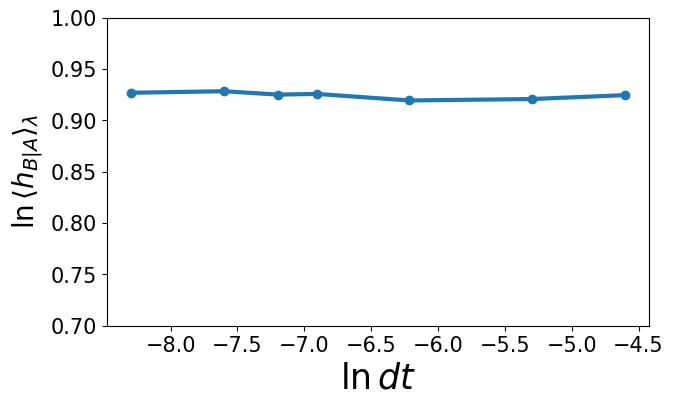

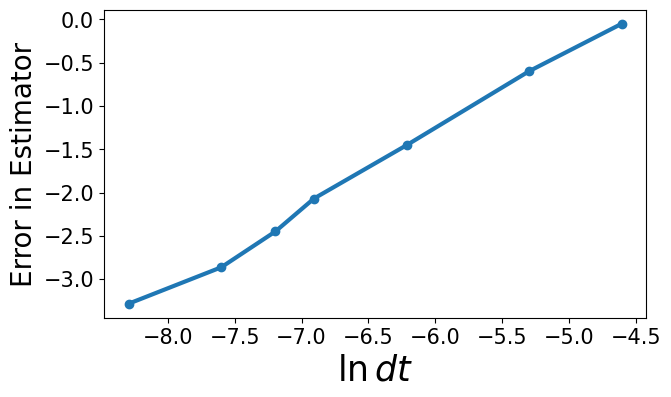

In [11]:
CAB = np.exp(-7.22) #Numerical estimate of the rate
driven_hBA = np.mean(idx,axis=-1)
driven_est = np.array([np.mean(U[i][idx[i]]) for i in range(dts.shape[0])]) + \
                np.log(driven_hBA)
error = np.log(CAB)-driven_est
plt.figure(figsize=(7,4))
plt.plot(np.log(dts),driven_hBA,'-o',lw=3)
plt.xlabel('$\\ln dt$',fontsize=25)
plt.ylim(0.7,1.0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('$\\ln \\langle h_{B|A} \\rangle_{\\lambda}$',fontsize=20)


plt.figure(figsize=(7,4))
plt.plot(np.log(dts),np.log(error),'-o',lw=3)

plt.xlabel('$\\ln dt$',fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Error in Estimator',fontsize=20)

# 3. Sensitivity to smoothing parameter $\sigma$
### To ensure that the gradients go to 0 smoothly in the A well, we perform a single parameter smoothing by fitting a 5th order spline between $x_l$ and $x_r$ defined as follows
### $x_l = x_A - \sigma/2, \; x_r = x_A + \sigma/2$
### where $\sigma$ is the range over which the spline is fitted. The fitting constrains the spline to have the same value of the committor its gradients and its hessian at $x_r$ and that all of these three terms are 0 at at $x_l$.
### We find that the the accuracy of the forces are the same for a large range of $\sigma$, consistent with the result that the constant form of the second eigenvector of the FPE inside metastable basins allows a straightforward analytial continuation of the splitting probability within the basins.

In [12]:
sigmas = np.arange(0,0.7,0.05)
tf = 2.0
dt = 0.001
nsteps = int(tf/dt)
U = np.zeros((sigmas.shape[0],ntraj))
idx = np.zeros((sigmas.shape[0],ntraj),dtype=bool)

for i in tqdm(range(sigmas.shape[0])):
    qssSpline, dqssSpline = getCommittorSplines(sigma=sigmas[i])
    getControlForce = getControlForceFunction(qssSpline,dqssSpline,pB,mu2)
    driven_traj = getDrivenTrajectories(confs_A, nsteps, getControlForce,dt=dt,
                                            eta_sig=eta_sig,verbose=False)
    idx[i] = hB(driven_traj[:,-1,0])
    U[i] = -np.sum(driven_traj[...,-1]**2 + 2*driven_traj[...,-1]*driven_traj[...,-2],
                    axis=-1)*dt/(4*gamma*kBT)

  0%|          | 0/14 [00:00<?, ?it/s]

Text(0, 0.5, 'Error in Estimator')

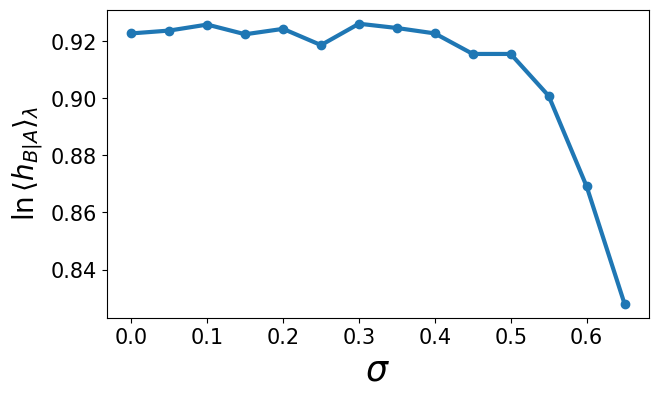

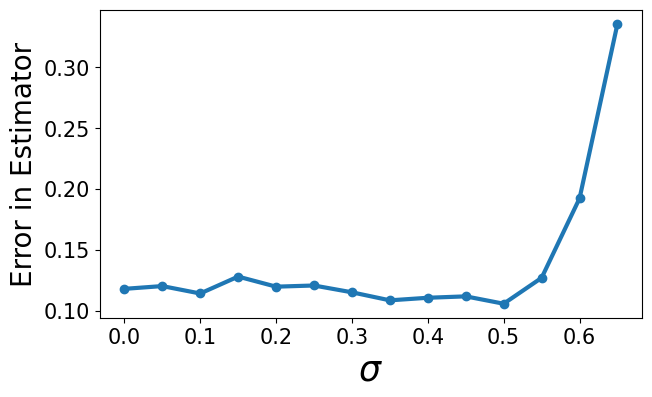

In [13]:
driven_hBA = np.mean(idx,axis=-1)
driven_est = np.array([np.mean(U[i][idx[i]]) for i in range(sigmas.shape[0])]) + \
                np.log(driven_hBA)
error = np.log(CAB)-driven_est
plt.figure(figsize=(7,4))
plt.plot(sigmas,driven_hBA,'-o',lw=3)
plt.xlabel('$\sigma$',fontsize=25)
#plt.ylim(0.7,1.0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('$\\ln \\langle h_{B|A} \\rangle_{\\lambda}$',fontsize=20)


plt.figure(figsize=(7,4))
plt.plot(sigmas,error,'-o',lw=3)

plt.xlabel('$\sigma$',fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Error in Estimator',fontsize=20)